<a href="https://colab.research.google.com/github/zergswim/Diffusion/blob/main/AttentionTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, random_split

# # MNIST 데이터셋 로드
# transform = transforms.Compose([transforms.ToTensor()])
# train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 데이터셋 준비
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# 훈련용과 검증용으로 데이터셋 나누기 (8:2 비율)
train_size = int(len(mnist_dataset) * 0.8)
val_size = len(mnist_dataset) - train_size
train_dataset, val_dataset = random_split(mnist_dataset, [train_size, val_size])

# DataLoader 준비
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# 이미지를 패치로 분할하는 함수
def image_to_patches(images, patch_size):
    B, C, H, W = images.shape
    images = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    images = images.permute(0, 2, 3, 1, 4, 5).contiguous()
    images = images.view(B, -1, C * patch_size * patch_size)
    return images

# 간단한 어텐션 모듈
class SimpleAttention(nn.Module):
    def __init__(self, patch_size):
        super(SimpleAttention, self).__init__()
        self.patch_size = patch_size
        self.scale = (patch_size * patch_size) ** -0.5
        self.query = nn.Linear(patch_size * patch_size, patch_size * patch_size)
        self.key = nn.Linear(patch_size * patch_size, patch_size * patch_size)
        self.value = nn.Linear(patch_size * patch_size, patch_size * patch_size)

    def forward(self, x):
        B, N, _ = x.shape
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        attention = F.softmax(attention_scores, dim=-1)
        out = torch.matmul(attention, V)
        return out, attention, (Q, K, V)

# 모델 정의
class PatchedMNISTModel(nn.Module):
    def __init__(self, patch_size=7):
        super(PatchedMNISTModel, self).__init__()
        self.patch_size = patch_size
        self.attention = SimpleAttention(patch_size)
        self.fc = nn.Linear(28*28, 10)  # Flatten 이미지를 위한 Fully Connected Layer

    def forward(self, x):
        x = image_to_patches(x, self.patch_size)
        x, attention, (Q, K, V) = self.attention(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return F.log_softmax(x, dim=1), attention, (Q, K, V)
        # return F.log_softmax(x, dim=1), _, _

# 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PatchedMNISTModel(patch_size=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

for epoch in range(20):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output, _, _ = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')


Train Epoch: 0 [0/48000 (0%)]	Loss: 2.413590
Train Epoch: 0 [6400/48000 (13%)]	Loss: 0.918845
Train Epoch: 0 [12800/48000 (27%)]	Loss: 1.046584
Train Epoch: 0 [19200/48000 (40%)]	Loss: 0.484760
Train Epoch: 0 [25600/48000 (53%)]	Loss: 0.648250
Train Epoch: 0 [32000/48000 (67%)]	Loss: 0.553087
Train Epoch: 0 [38400/48000 (80%)]	Loss: 0.515687
Train Epoch: 0 [44800/48000 (93%)]	Loss: 0.781608
Train Epoch: 1 [0/48000 (0%)]	Loss: 0.557075
Train Epoch: 1 [6400/48000 (13%)]	Loss: 0.589770
Train Epoch: 1 [12800/48000 (27%)]	Loss: 0.434900
Train Epoch: 1 [19200/48000 (40%)]	Loss: 0.591357
Train Epoch: 1 [25600/48000 (53%)]	Loss: 0.358432
Train Epoch: 1 [32000/48000 (67%)]	Loss: 0.619681
Train Epoch: 1 [38400/48000 (80%)]	Loss: 0.694751
Train Epoch: 1 [44800/48000 (93%)]	Loss: 0.507765
Train Epoch: 2 [0/48000 (0%)]	Loss: 0.383071
Train Epoch: 2 [6400/48000 (13%)]	Loss: 0.458560
Train Epoch: 2 [12800/48000 (27%)]	Loss: 0.584937
Train Epoch: 2 [19200/48000 (40%)]	Loss: 0.563813
Train Epoch: 2 [25

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

print(device)

# 성능 평가
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for data, target in val_loader:
        data = data.to(device)
        output, _, _ = model(data)
        pred = output.argmax(dim=1, keepdim=True).squeeze()
        y_true.extend(target.tolist())
        y_pred.extend(pred.tolist())

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

# MNIST with attention
# Accuracy: 0.9158333333333334
# F1 Score: 0.9149314304026159

# MNIST no attention
# Accuracy: 0.911
# F1 Score: 0.9094455053021699

# FashionMNIST with attention
# Accuracy: 0.8304166666666667
# F1 Score: 0.8299622108276224

# FashionMNIST no attention
# Accuracy: 0.8495
# F1 Score: 0.8478174169888939

cuda
Accuracy: 0.8345
F1 Score: 0.8339350268862822


tensor(9) tensor(9)


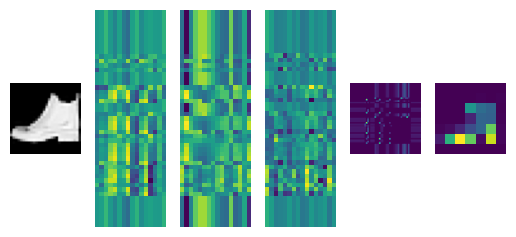

tensor(9) tensor(9)


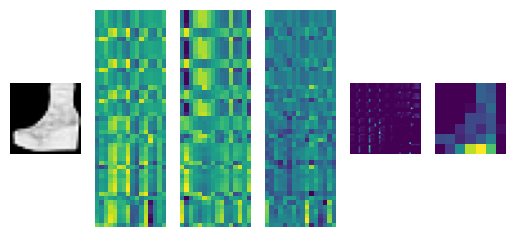

tensor(8) tensor(8)


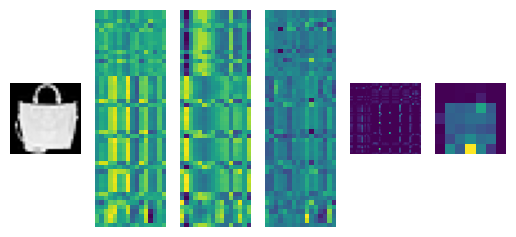

tensor(1) tensor(1)


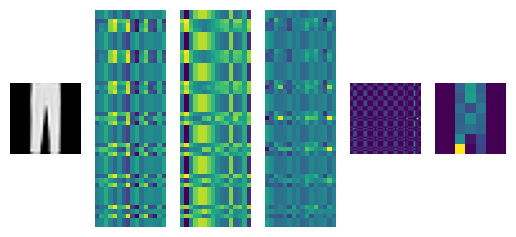

tensor(7) tensor(7)


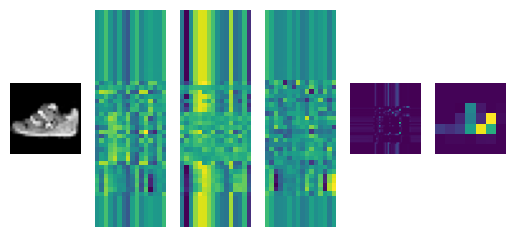

tensor(3) tensor(3)


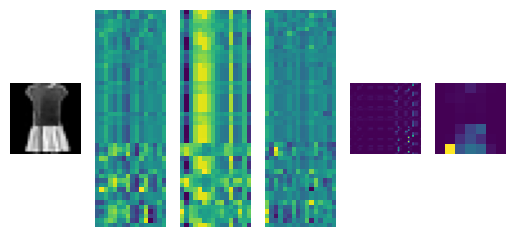

tensor(2) tensor(4)


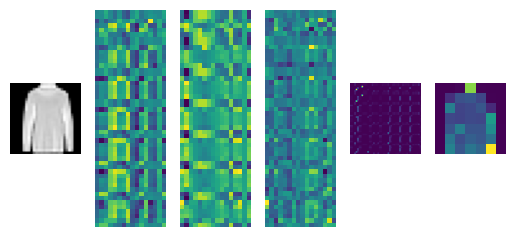

tensor(9) tensor(9)


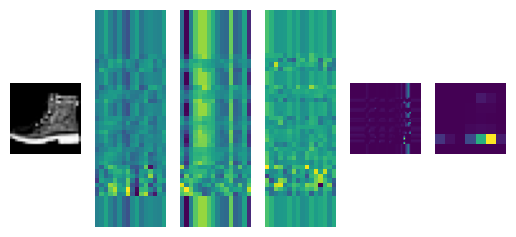

tensor(3) tensor(3)


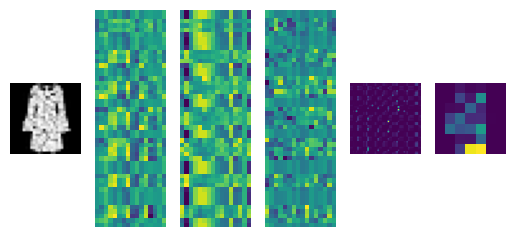

tensor(7) tensor(7)


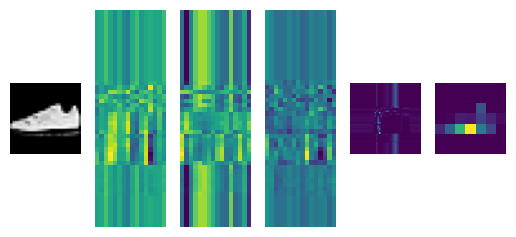

tensor(1) tensor(1)


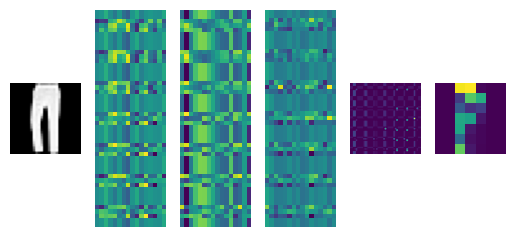

tensor(8) tensor(8)


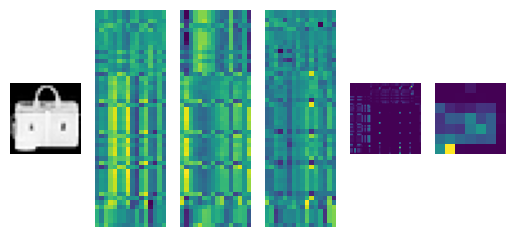

tensor(7) tensor(7)


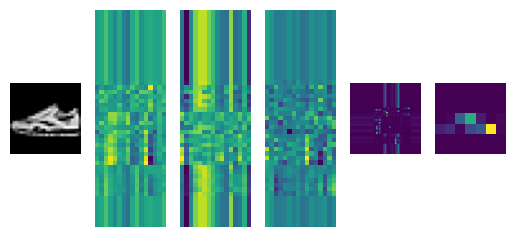

tensor(8) tensor(8)


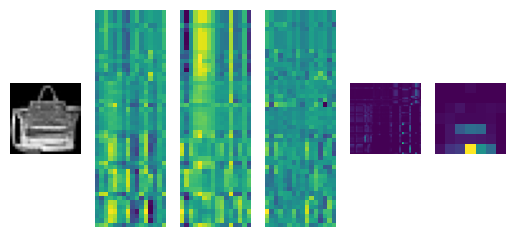

tensor(8) tensor(8)


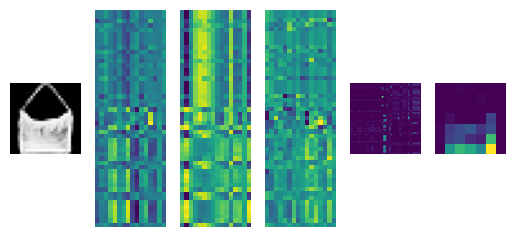

tensor(2) tensor(4)


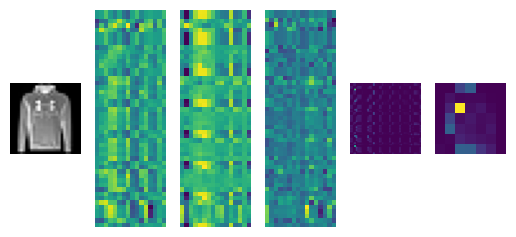

tensor(8) tensor(8)


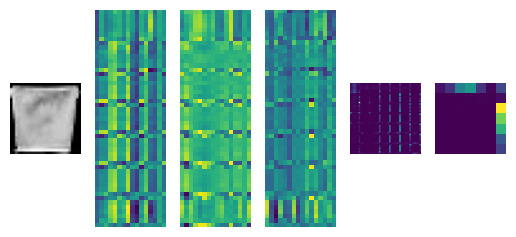

tensor(9) tensor(9)


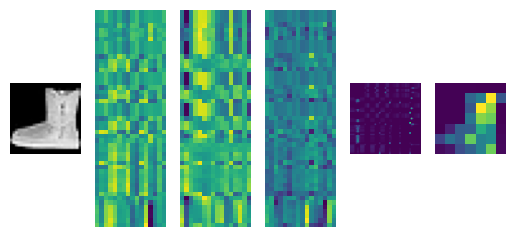

tensor(5) tensor(5)


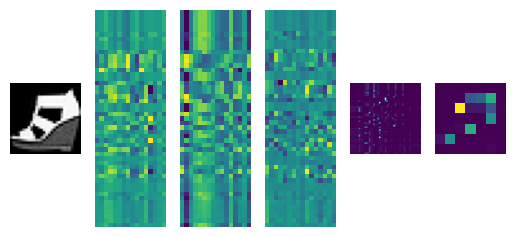

tensor(8) tensor(8)


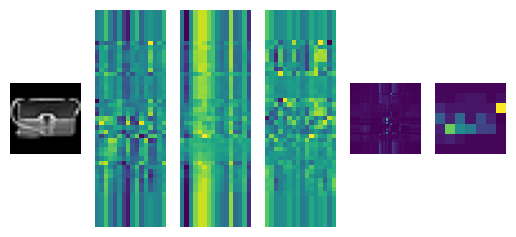

tensor(7) tensor(7)


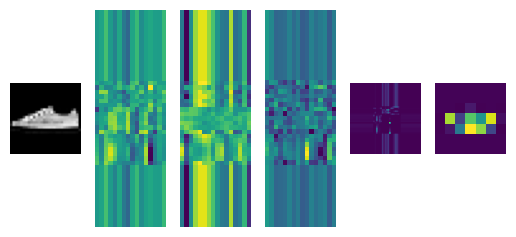

tensor(9) tensor(9)


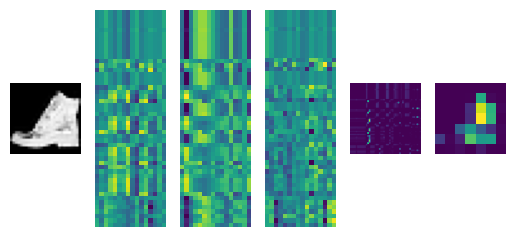

tensor(6) tensor(6)


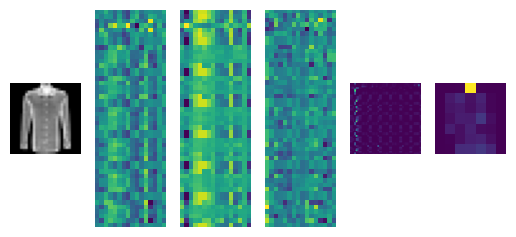

tensor(0) tensor(6)


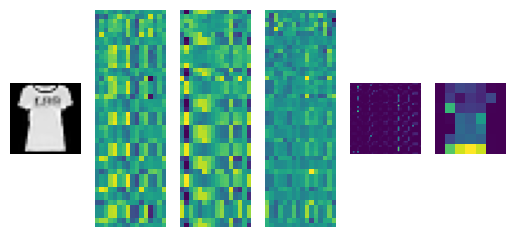

tensor(9) tensor(9)


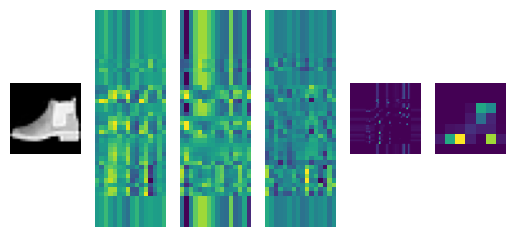

tensor(3) tensor(6)


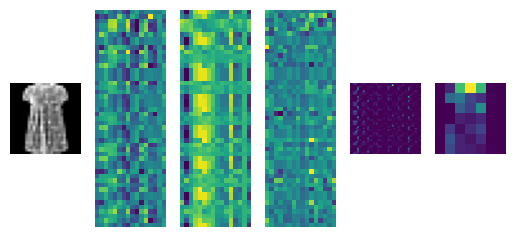

tensor(4) tensor(4)


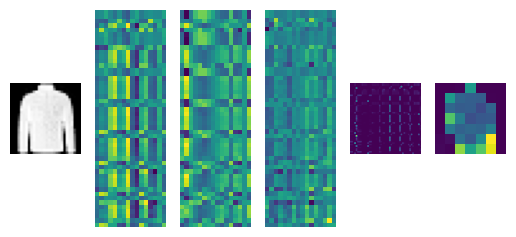

tensor(7) tensor(7)


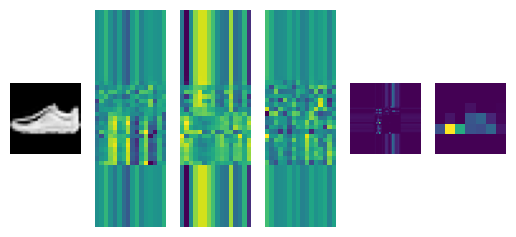

tensor(3) tensor(1)


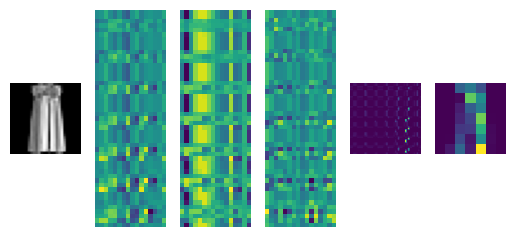

tensor(5) tensor(5)


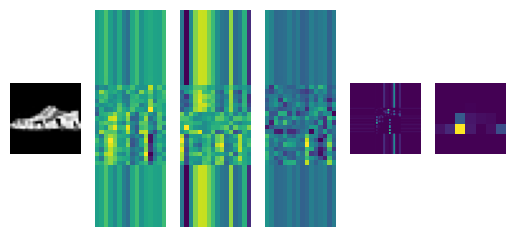

tensor(8) tensor(2)


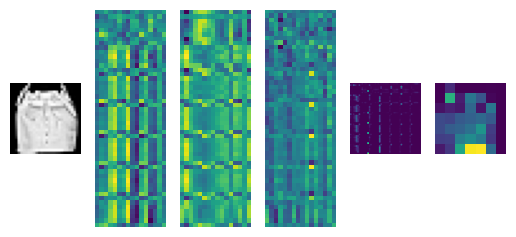

tensor(4) tensor(4)


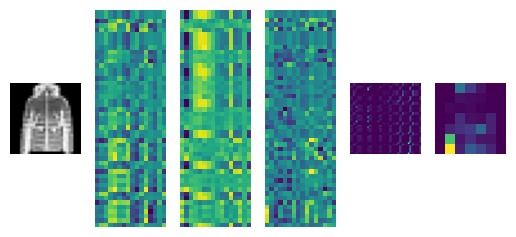

tensor(5) tensor(5)


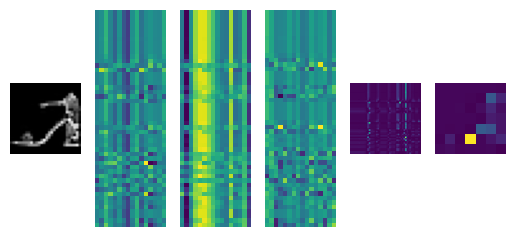

tensor(4) tensor(4)


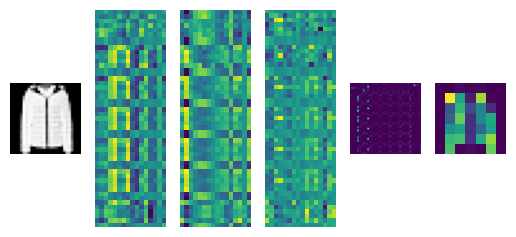

tensor(5) tensor(5)


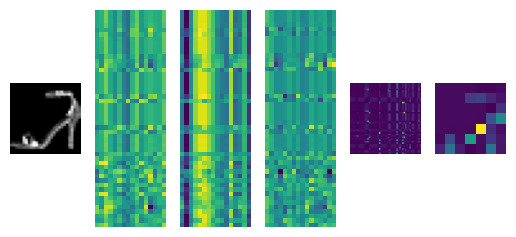

tensor(5) tensor(5)


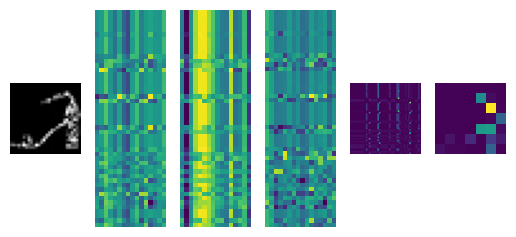

tensor(4) tensor(4)


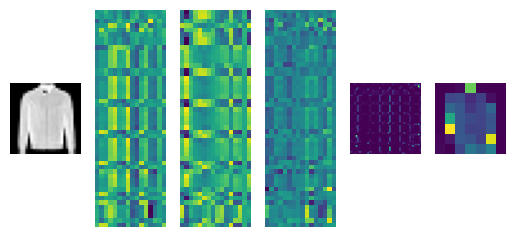

tensor(4) tensor(4)


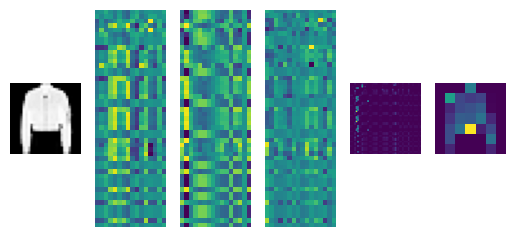

tensor(2) tensor(2)


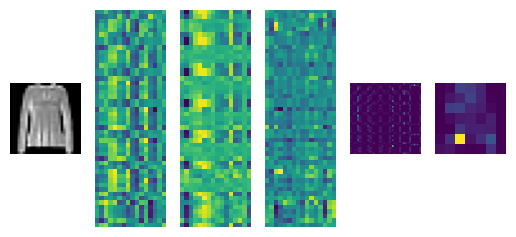

tensor(0) tensor(0)


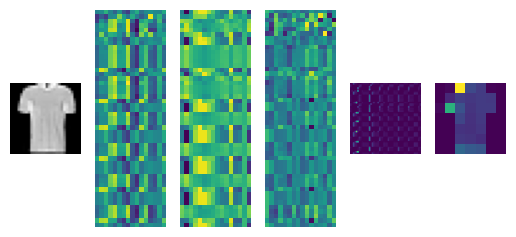

tensor(1) tensor(1)


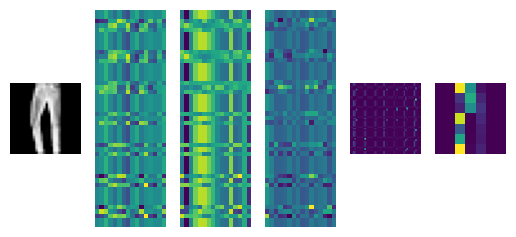

tensor(3) tensor(3)


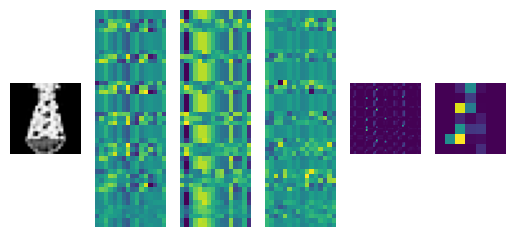

tensor(1) tensor(1)


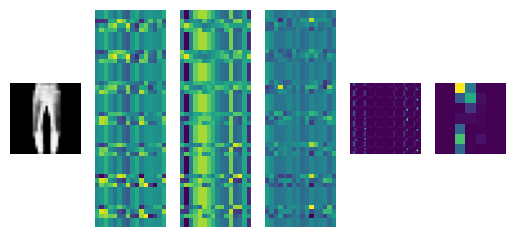

tensor(6) tensor(6)


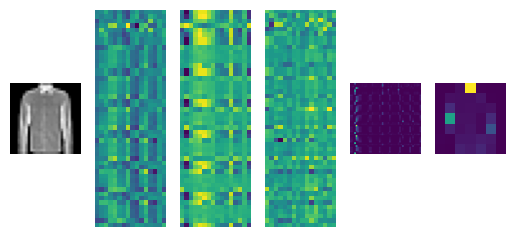

tensor(8) tensor(8)


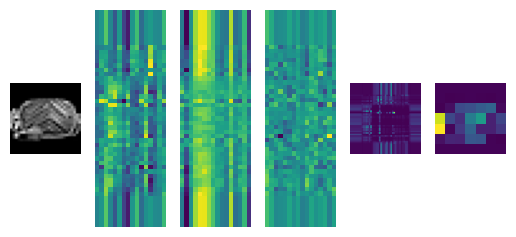

tensor(4) tensor(4)


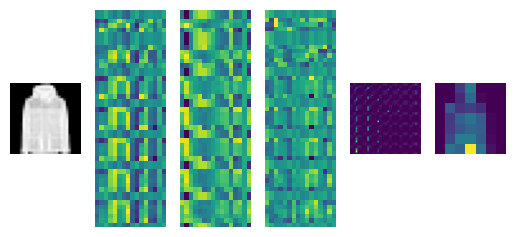

tensor(3) tensor(3)


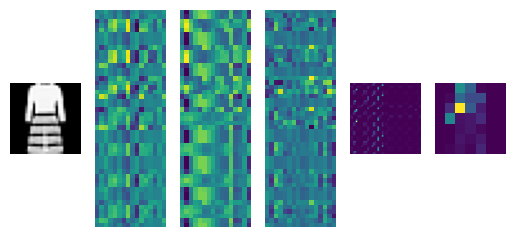

tensor(9) tensor(9)


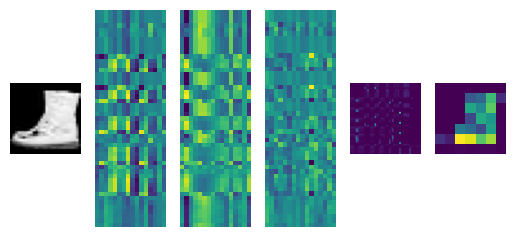

tensor(0) tensor(6)


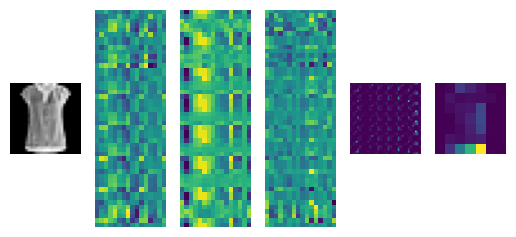

tensor(0) tensor(0)


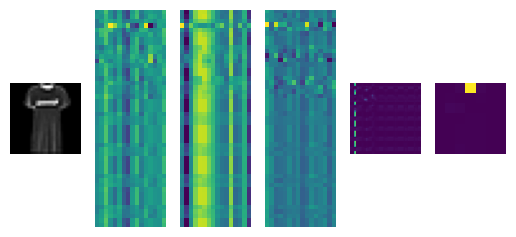

tensor(5) tensor(5)


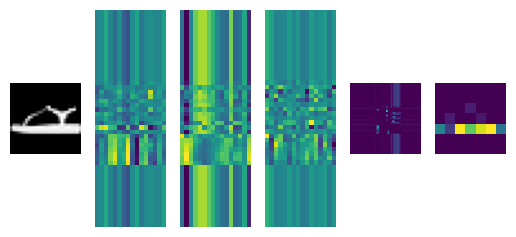

tensor(6) tensor(6)


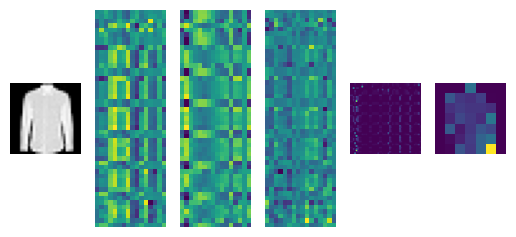

tensor(5) tensor(5)


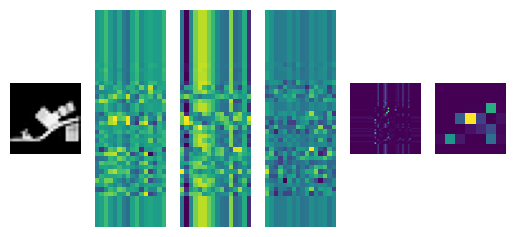

tensor(4) tensor(4)


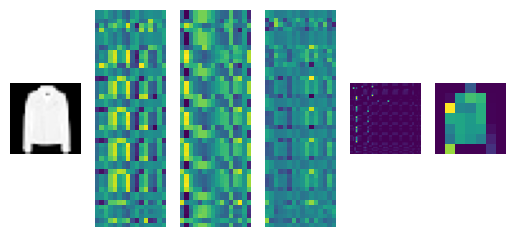

tensor(8) tensor(8)


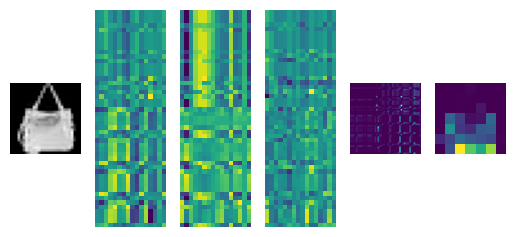

tensor(8) tensor(8)


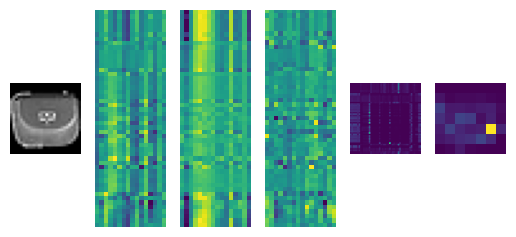

tensor(9) tensor(9)


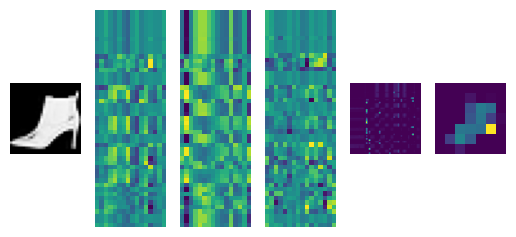

tensor(6) tensor(6)


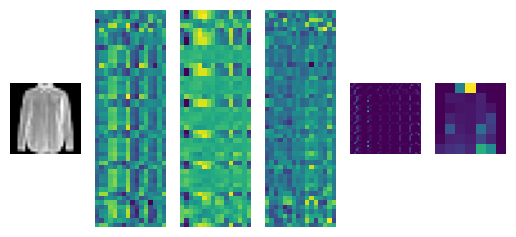

tensor(8) tensor(8)


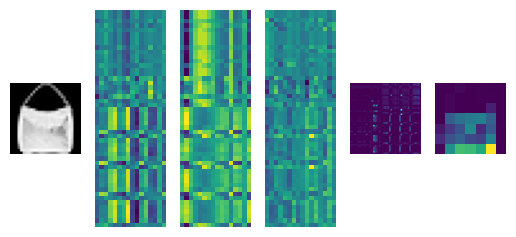

tensor(8) tensor(8)


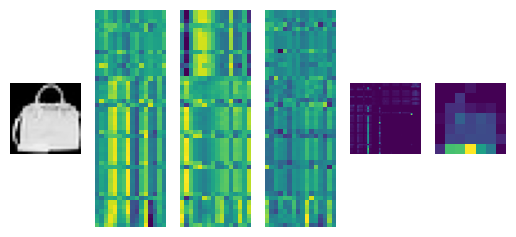

tensor(8) tensor(8)


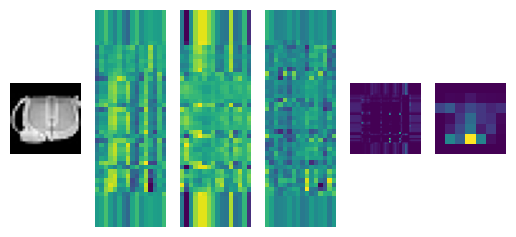

tensor(2) tensor(3)


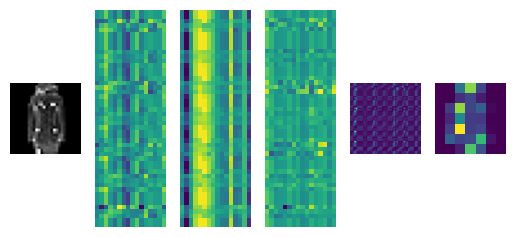

tensor(2) tensor(2)


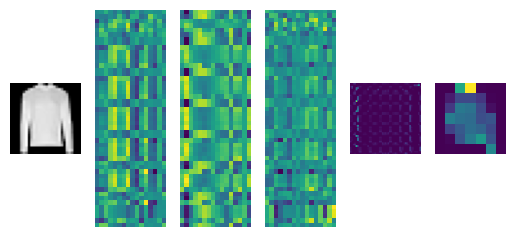

tensor(1) tensor(1)


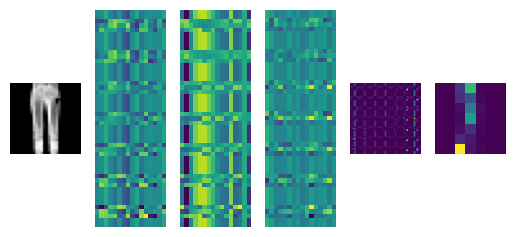

In [ ]:
# 모델 사용 후 어텐션 가중치 시각화 (예시)
import matplotlib.pyplot as plt
import numpy as np

# 데이터셋에서 하나의 샘플을 가져옴
data, label = next(iter(train_loader))
# data = data[:1]  # 배치에서 첫 번째 샘플만 사용
# label = label[:1]  # 배치에서 첫 번째 샘플만 사용

# 모델을 통해 예측 및 어텐션 가중치 추출
model.eval()  # 평가 모드
model = model.cpu()

with torch.no_grad():
    # data = data.to(device)
    # context, _, _ = model(data)
    context, weights, (q,k,v) = model(data)
    # print(label, np.argmax(context), context) #, q.shape,k.shape,v.shape)
    # print(weights.shape)

# 가중치 텐서에서 단일 값을 추출합니다.
# weight_value = weights.item()

# 가중치 값을 출력합니다.
#print("Attention weight value:", weight_value)

    for idx in range(context.size(0)):
        print(label[idx] , np.argmax(context[idx]) ) #, q.shape,k.shape,v.shape)
        plt.subplot(1, 6, 1)
        plt.imshow(data[idx].view(28, 28), cmap='Greys_r')
        plt.axis('off')

        plt.subplot(1, 6, 2)
        # print(q[idx].shape) #.squeeze().shape)
        plt.imshow(q[idx])
        plt.axis('off')

        plt.subplot(1, 6, 3)
        plt.imshow(k[idx])
        plt.axis('off')

        plt.subplot(1, 6, 4)
        plt.imshow(v[idx])
        plt.axis('off')

        size = weights[idx].size(0)
        # print(size**0.5, weights[idx].shape)
        query_pixel_index = 0
        weight = weights[idx].reshape(1, size, size)
        attention_map = weight[0, query_pixel_index, :].reshape(int(size**0.5), int(size**0.5))

        plt.subplot(1, 6, 5)
        plt.imshow(weights[idx])
        plt.axis('off')

        # plt.subplot(1, 8, 6)
        # plt.imshow(attention_map.permute(1, 0))
        # plt.axis('off')

        plt.subplot(1, 6, 6)
        plt.imshow(attention_map)
        plt.axis('off')

        # plt.subplot(1, 8, 8)
        # plt.imshow(weights[idx].permute(1, 0))
        # plt.axis('off')
        plt.show()


        # break

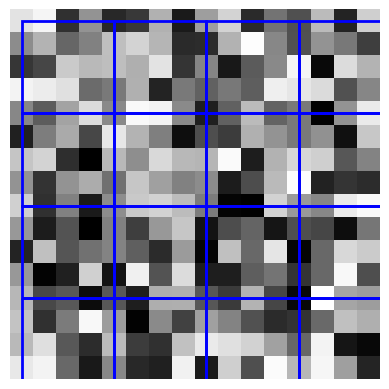

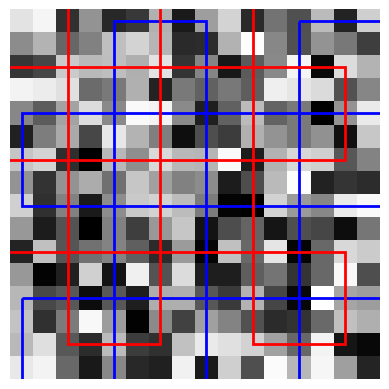

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_image_patches(img, patch_size=4, shifted=False, shift_size=2):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')

    # 이미지 크기
    img_size = img.shape[0]

    # 패치 또는 윈도우 그리기
    for x in range(0, img_size, patch_size):
        for y in range(0, img_size, patch_size):
            if shifted and (x+y) % (2*patch_size) == 0:
                # Shifted Window
                ax.add_patch(plt.Rectangle((y-shift_size, x-shift_size), patch_size, patch_size,
                                           edgecolor='red', facecolor='none', lw=2))
            else:
                # Regular Patch
                ax.add_patch(plt.Rectangle((y, x), patch_size, patch_size,
                                           edgecolor='blue', facecolor='none', lw=2))
    plt.axis('off')
    plt.show()

# 간단한 그레이스케일 이미지 생성
img_size = 16
img = np.random.rand(img_size, img_size)

# 이미지를 패치로 분할하는 어텐션 시각화
plot_image_patches(img, patch_size=4, shifted=False)

# Shifted Window 어텐션 시각화
plot_image_patches(img, patch_size=4, shifted=True)


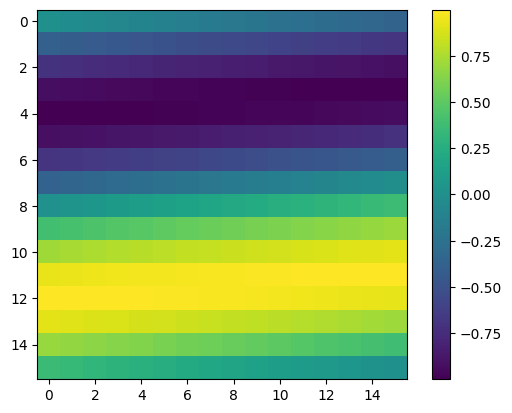

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54589 (\N{HANGUL SYLLABLE PIG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49472 (\N{HANGUL SYLLABLE SEL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages

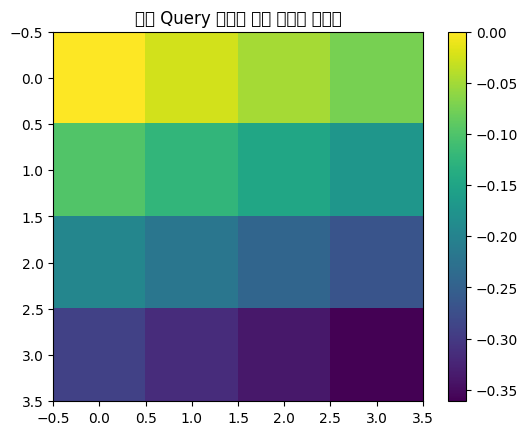

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 예를 들어, attention_weights는 [batch_size, seq_len, seq_len] 형태의 텐서
# 여기서는 단순화를 위해 batch_size = 1, seq_len = 28*28이라고 가정
# attention_weights = np.random.normal(1, 28*28, 28*28)  # 랜덤 가중치 생성

# x = np.sin(np.linspace(-np.pi, np.pi, 28*28 * 28*28))
# plt.plot(x)
# plt.show()

# attention_weights = attention_weights.reshape(1, 28*28, 28*28)  # 랜덤 가중치 생성
attention_weights = np.sin(np.linspace(-np.pi, np.pi, 16 * 16))
attention_weights = attention_weights.reshape(1, 16, 16)

plt.imshow(attention_weights.reshape(16, 16), cmap='viridis')
plt.colorbar()
plt.show()

# # 특정 query 픽셀 선택 (예: 0번째 픽셀)
query_pixel_index = 0
query_attention = attention_weights[0, query_pixel_index, :].reshape(4, 4)

plt.imshow(query_attention, cmap='viridis')
plt.colorbar()
plt.title("특정 Query 픽셀에 대한 어텐션 가중치")
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


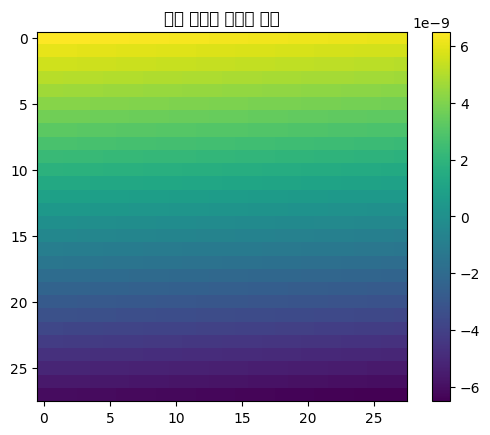

In [ ]:
# 전체 어텐션 가중치 평균 내기
average_attention = np.mean(attention_weights[0], axis=0).reshape(28, 28)

plt.imshow(average_attention, cmap='viridis')
plt.colorbar()
plt.title("전체 어텐션 가중치 평균")
plt.show()
